In [1]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/runner/work/numpyro-doing-bayesian/numpyro-doing-bayesian


In [2]:
import arviz as az
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
import numpy as np
import numpyro
from numpyro.infer import MCMC, NUTS, HMC, SA
from numpyro.infer.initialization import init_to_median
import numpyro_glm.metric.models as glm_metric
import pandas as pd
import seaborn as sns
from scipy.stats import norm, t

numpyro.set_host_device_count(2)

# Chapter 20: Metric Predicted Variable with Multiple Nominal Predictors
## Hierarchical Bayesian Approach

In [3]:
salary_df = pd.read_csv('datasets/Salary.csv')
salary_df['Org'] = salary_df['Org'].astype('category')
salary_df['Pos'] = (salary_df['Pos']
                    .astype('category').cat
                    .set_categories(['FT3', 'FT2', 'FT1', 'NDW', 'DST']).cat
                    .rename_categories(['Assoc', 'Assis', 'Full', 'Endow', 'Disting']))
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1080 entries, 0 to 1079
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   Org      1080 non-null   category
 1   OrgName  1080 non-null   object  
 2   Cla      1080 non-null   object  
 3   Pos      1080 non-null   category
 4   ClaPos   1080 non-null   object  
 5   Salary   1080 non-null   int64   
dtypes: category(2), int64(1), object(3)
memory usage: 38.7+ KB


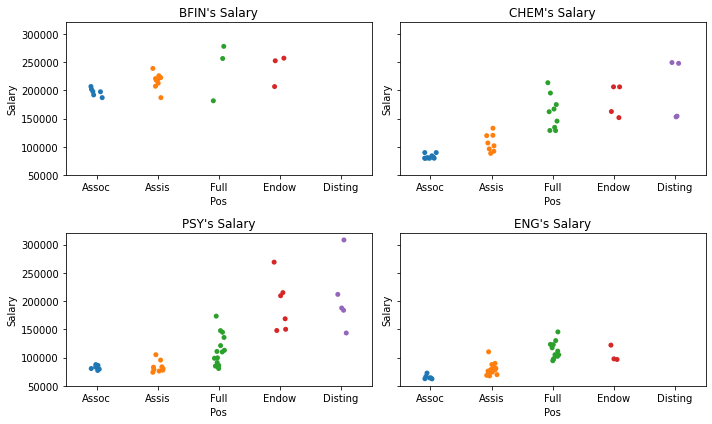

In [4]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 6),
    sharey=True)

departments = ['BFIN', 'CHEM', 'PSY', 'ENG']
for department, ax in zip(departments, axes.flatten()):
    df = salary_df[salary_df['Org'] == department]
    sns.stripplot(x='Pos', y='Salary', data=df, ax=ax)
    ax.set_title(f'{department}\'s Salary')

fig.tight_layout()

In [5]:
kernel = NUTS(glm_metric.multi_nominal_predictors, target_accept_prob=0.99)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=10000, num_chains=2)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(salary_df['Salary'].values),
    grp=jnp.concatenate([salary_df[c].cat.codes.values[..., None]
                        for c in ['Org', 'Pos']], axis=1),
    nb_groups=(salary_df['Org'].cat.categories.size,
               salary_df['Pos'].cat.categories.size),
)
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
         a0_      0.07      0.12      0.07     -0.11      0.28   4534.21      1.00
      a1_[0]      2.65      0.34      2.65      2.08      3.18   3793.30      1.00
      a1_[1]     -0.49      0.33     -0.49     -1.04      0.04   6474.50      1.00
      a1_[2]     -0.54      0.33     -0.54     -1.10     -0.01   6802.61      1.00
      a1_[3]     -0.62      0.26     -0.62     -1.05     -0.19   4551.31      1.00
      a1_[4]      0.10      0.26      0.10     -0.33      0.53   3996.38      1.00
      a1_[5]      0.00      0.30      0.00     -0.47      0.50   6425.42      1.00
      a1_[6]      1.58      0.32      1.58      1.06      2.10   4642.88      1.00
      a1_[7]      3.53      0.40      3.52      2.88      4.18   3593.65      1.00
      a1_[8]     -0.11      0.22     -0.11     -0.47      0.24   3496.25      1.00
      a1_[9]      0.59      0.30      0.58      0.10      1.08   5916.65      1.00
   

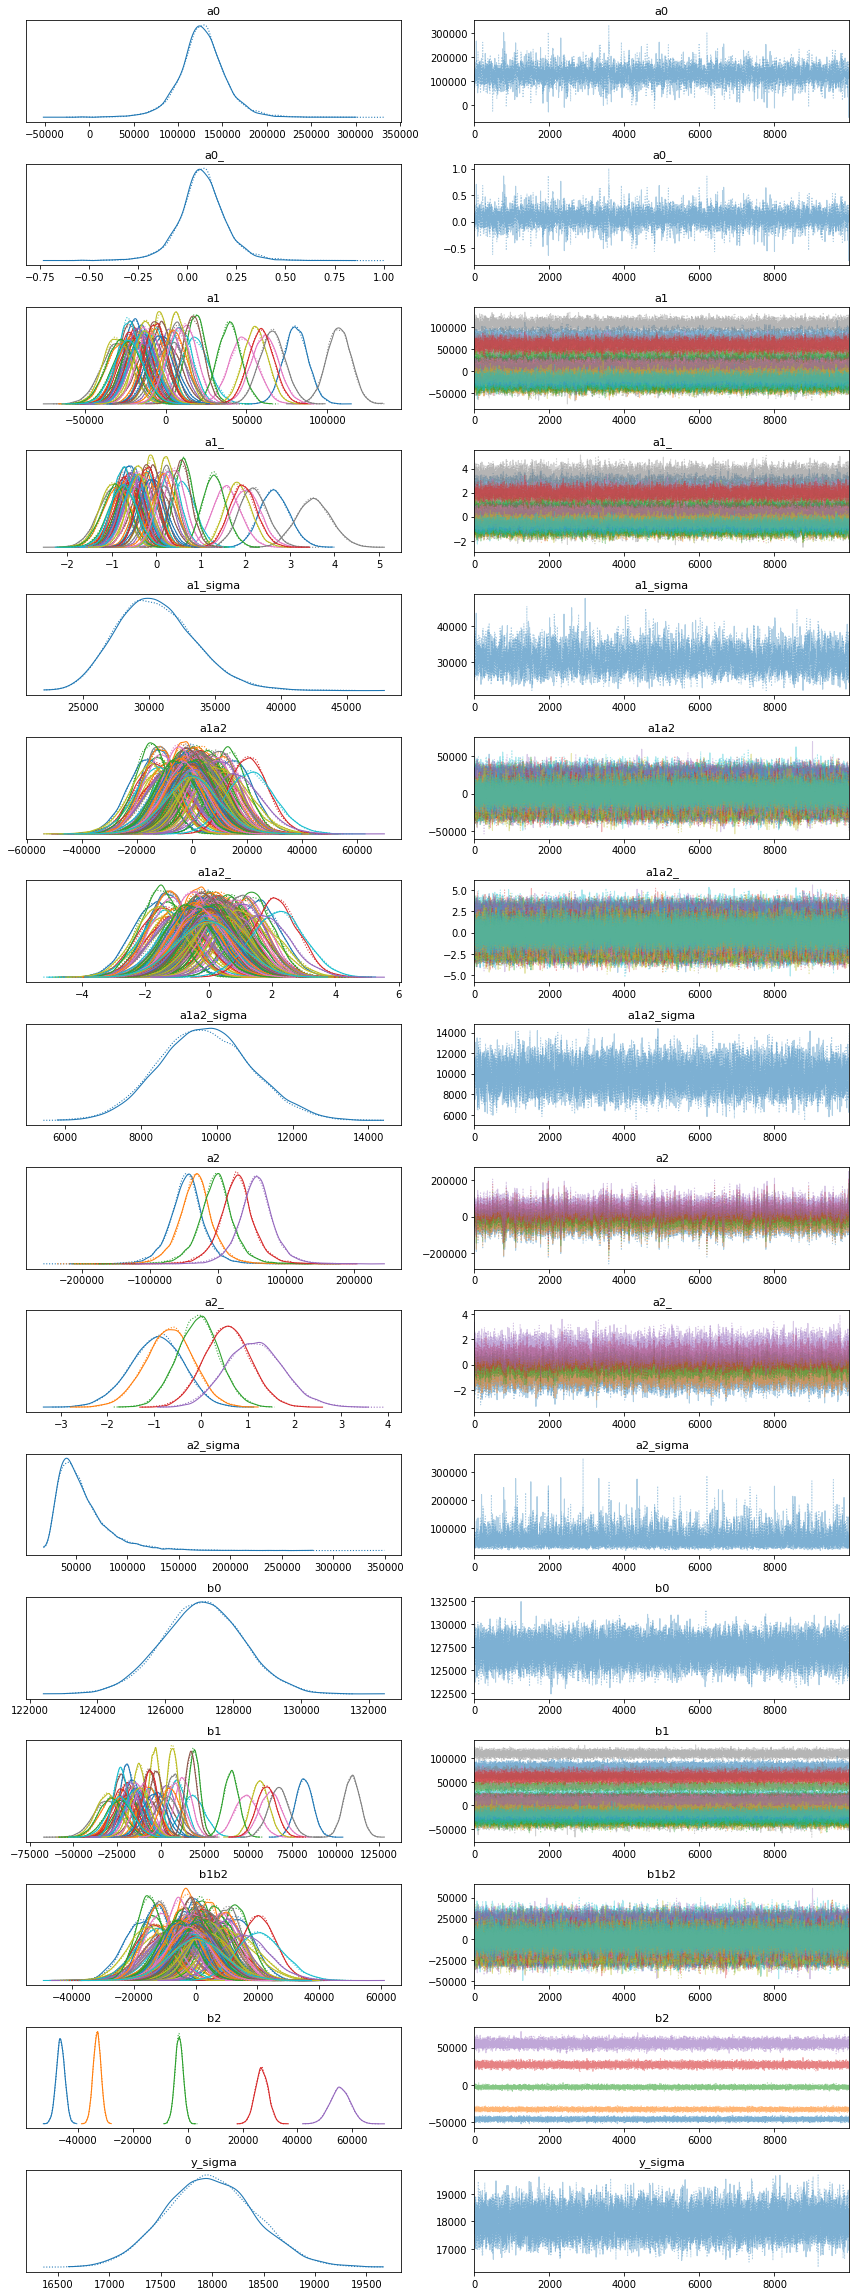

In [6]:
idata_hom = az.from_numpyro(
    mcmc,
    coords=dict(org=salary_df['Org'].cat.categories.values,
                pos=salary_df['Pos'].cat.categories.values),
    dims=dict(b1=['org'],
              b2=['pos'],
              b1b2=['org', 'pos']),
)
az.plot_trace(idata_hom)
plt.tight_layout()

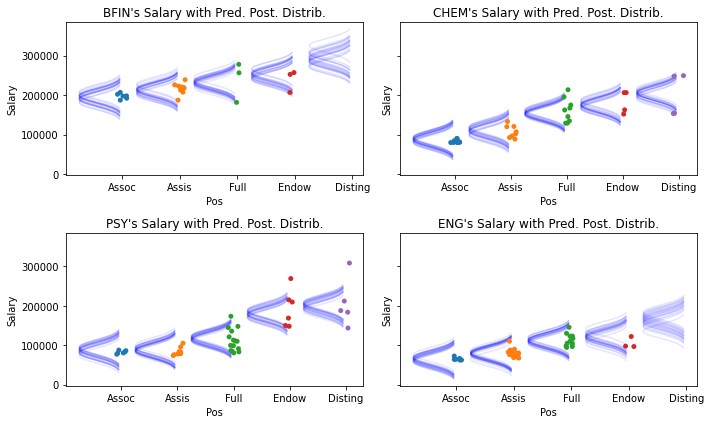

In [7]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 6),
    sharey=True)

n_curves = 20
for org, ax in zip(departments, axes.flatten()):
    # Plot data.
    df = salary_df[salary_df['Org'] == org]
    sns.stripplot(x='Pos', y='Salary', data=df, ax=ax)
    ax.set_title(f'{org}\'s Salary with Pred. Post. Distrib.')

    # Plot posterior distribution.
    posterior = idata_hom.posterior
    b0 = posterior['b0'].values.flatten()
    b1 = posterior['b1'].sel(org=org).values.flatten()
    y_sigma = posterior['y_sigma'].values.flatten()

    curve_indices = np.random.choice(
        posterior.draw.size * posterior.chain.size, n_curves, replace=False)

    for pos_i, pos in enumerate(salary_df['Pos'].cat.categories):
        b2 = posterior['b2'].sel(pos=pos).values.flatten()
        b1b2 = posterior['b1b2'].sel(org=org, pos=pos).values.flatten()

        mean = b0 + b1 + b2 + b1b2

        for idx in curve_indices:
            rv = norm(mean[idx], y_sigma[idx])
            yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
            xpdf = rv.pdf(yrange)

            # Scale xpdf
            xpdf = xpdf * 0.75 / np.max(xpdf)

            # Plot pdf curve.
            ax.plot(pos_i - xpdf, yrange, c='b', alpha=.1)

fig.tight_layout()

### Contrasts

In [8]:
def plot_contrasts(
        idata, coef: str,
        left_sel: 'dict[str, list[str]]',
        right_sel: 'dict[str, list[str]]',
        comp_val: float = None,
        rope: 'tuple[float, float]' = None,
        ax: plt.Axes = None):
    """
    Plot contrasts based on inference data from 2 nominal predictors
    and homogeneous normal model.

    Parameters
    ----------
    idata: az.InferenceData
        Inference Data converted from numpyro's MCMC object.
    coef: str
        Name of the coefficient to be used for contrasts comparison.
    left_sel: dict[str, list[str]]
        Selector that will be passed to .sel() function.
    right_sel: dict[str, list[str]]
        Selector that will be passed to .sel() function.
    ax: plt.Axes
        Axes to be used. If None, then new axes will be created.
    """
    def average_last_dim_if_necessary(values):
        if values.ndim == 2:
            return values

        values = np.reshape(values, (*values.shape[:2], -1))
        return np.mean(values, axis=-1)

    if ax is None:
        _, ax = plt.subplots()

    posterior = idata.posterior
    left_values = average_last_dim_if_necessary(
        posterior[coef].sel(left_sel).values)
    right_values = average_last_dim_if_necessary(
        posterior[coef].sel(right_sel).values)

    diff = left_values - right_values
    az.plot_posterior(
        diff, point_estimate='median', hdi_prob=0.95, ref_val=comp_val, rope=rope, ax=ax)
    ax.set_xlabel('Difference')

    return ax

#### Main Effect Contrasts

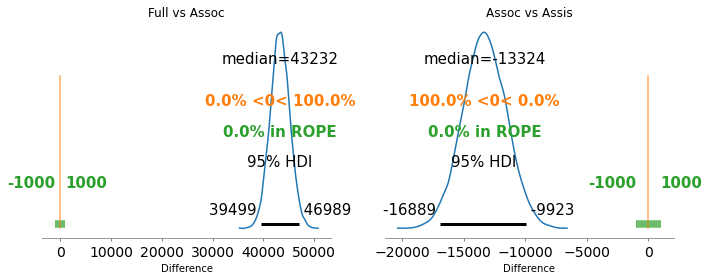

In [9]:
pos_contrasts = [
    dict(left='Full', right='Assoc', comp_val=0.0, rope=(-1000, 1000)),
    dict(left='Assoc', right='Assis', comp_val=0.0, rope=(-1000, 1000)),
]

fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for contrast, ax in zip(pos_contrasts, axes):
    plot_contrasts(
        idata_hom, 'b2',
        left_sel=dict(pos=contrast['left']),
        right_sel=dict(pos=contrast['right']),
        comp_val=contrast['comp_val'],
        rope=contrast['rope'],
        ax=ax)
    ax.set_title(f'{contrast["left"]} vs {contrast["right"]}')

fig.tight_layout()

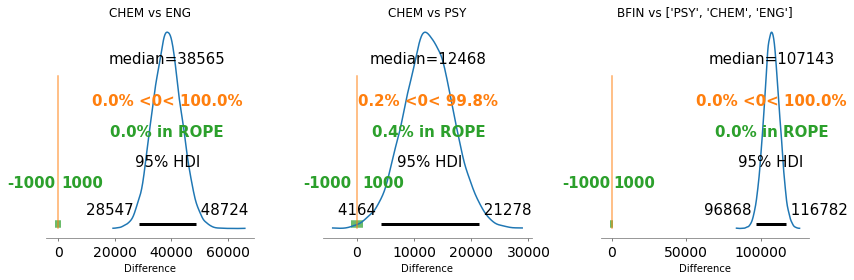

In [10]:
org_contrasts = [
    dict(left='CHEM', right='ENG', comp_val=0.0, rope=(-1000, 1000)),
    dict(left='CHEM', right='PSY', comp_val=0.0, rope=(-1000, 1000)),
    dict(left='BFIN', right=['PSY', 'CHEM', 'ENG'],
         comp_val=0.0, rope=(-1000, 1000)),
]

fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for contrast, ax in zip(org_contrasts, axes):
    plot_contrasts(
        idata_hom, 'b1',
        left_sel=dict(org=contrast['left']),
        right_sel=dict(org=contrast['right']),
        comp_val=contrast['comp_val'],
        rope=contrast['rope'],
        ax=ax)
    ax.set_title(f'{contrast["left"]} vs {contrast["right"]}')

fig.tight_layout()

#### Interaction Contrasts
TODO

## Heterogeneous Variances and Robustness against Outliers

In [11]:
kernel = NUTS(
    glm_metric.multi_nominal_predictors_het_var_robust,
    init_strategy=init_to_median)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=5000, num_chains=2)
mcmc.run(
    random.PRNGKey(0),
    y=jnp.array(salary_df['Salary'].values),
    grp=jnp.concatenate([salary_df[c].cat.codes.values[..., None]
                        for c in ['Org', 'Pos']], axis=1),
    y_sds=jnp.array(salary_df.groupby(['Org', 'Pos']).std().dropna().values),
    nb_groups=(salary_df['Org'].cat.categories.size,
               salary_df['Pos'].cat.categories.size),
)
mcmc.print_summary()


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
           a0_      0.08      0.12      0.07     -0.09      0.28      1.25      3.31
        a1_[0]      3.08      0.34      2.95      2.67      3.66      1.93      1.75
        a1_[1]     -0.44      0.23     -0.42     -0.83     -0.08      2.05      1.46
        a1_[2]     -0.54      0.12     -0.54     -0.75     -0.35     18.36      1.15
        a1_[3]     -0.63      0.15     -0.61     -0.85     -0.36     10.66      1.16
        a1_[4]     -0.15      0.12     -0.14     -0.32      0.06     13.80      1.22
        a1_[5]     -0.38      0.15     -0.37     -0.62     -0.13     14.64      1.08
        a1_[6]      1.51      0.22      1.50      1.11      1.83      4.27      1.26
        a1_[7]      3.71      0.43      3.64      3.06      4.36      2.50      1.53
        a1_[8]     -0.10      0.09     -0.11     -0.24      0.05     23.59      1.05
        a1_[9]      0.64      0.15      0.63      0.43      0.90

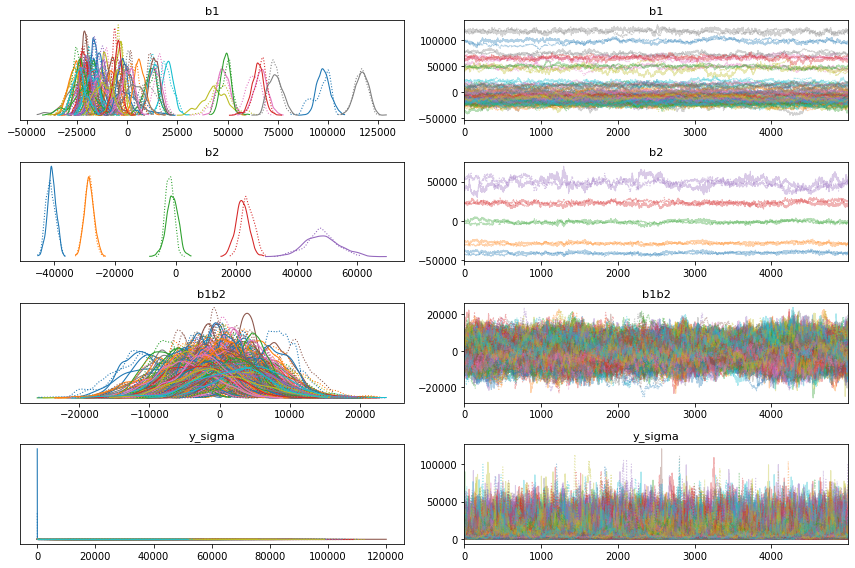

In [12]:
idata_het = az.from_numpyro(
    mcmc,
    coords=dict(org=salary_df['Org'].cat.categories.values,
                pos=salary_df['Pos'].cat.categories.values),
    dims=dict(b1=['org'],
              b2=['pos'],
              b1b2=['org', 'pos'],
              y_sigma=['org', 'pos']),
)
az.plot_trace(idata_het, ['b1', 'b2', 'b1b2', 'y_sigma'])
plt.tight_layout()

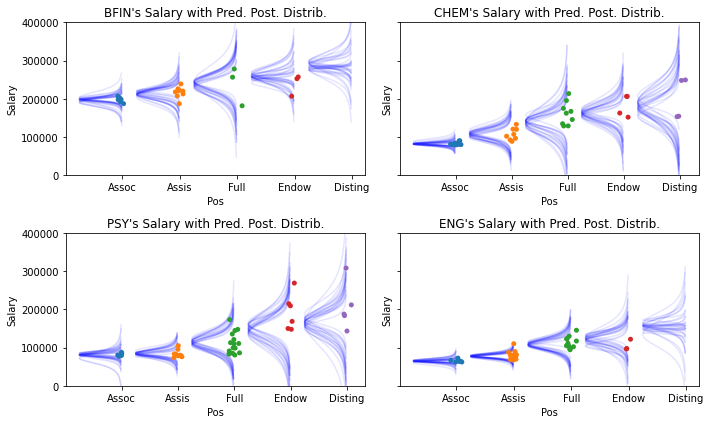

In [13]:
fig, axes = plt.subplots(
    nrows=2, ncols=2,
    figsize=(10, 6),
    sharey=True)

n_curves = 20
for org, ax in zip(departments, axes.flatten()):
    # Plot data.
    df = salary_df[salary_df['Org'] == org]
    sns.stripplot(x='Pos', y='Salary', data=df, ax=ax)
    ax.set_title(f'{org}\'s Salary with Pred. Post. Distrib.')

    # Plot posterior distribution.
    posterior = idata_het.posterior
    b0 = posterior['b0'].values.flatten()
    b1 = posterior['b1'].sel(org=org).values.flatten()
    nu = posterior['nu'].values.flatten()

    curve_indices = np.random.choice(
        posterior.draw.size * posterior.chain.size, n_curves, replace=False)

    for pos_i, pos in enumerate(salary_df['Pos'].cat.categories):
        b2 = posterior['b2'].sel(pos=pos).values.flatten()
        b1b2 = posterior['b1b2'].sel(org=org, pos=pos).values.flatten()
        y_sigma = posterior['y_sigma'].sel(org=org, pos=pos).values.flatten()

        mean = b0 + b1 + b2 + b1b2

        for idx in curve_indices:
            rv = t(nu[idx], mean[idx], y_sigma[idx])
            yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 1000)
            xpdf = rv.pdf(yrange)

            # Scale xpdf
            xpdf = xpdf * 0.75 / np.max(xpdf)

            # Plot pdf curve.
            ax.plot(pos_i - xpdf, yrange, c='b', alpha=.1)

    ax.set_ylim(0, 400000)

fig.tight_layout()

/usr/share/miniconda/lib/python3.7/site-packages/arviz/plots/plot_utils.py:277: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (301) in plot_posterior, generating only 40 plots
  UserWarning,


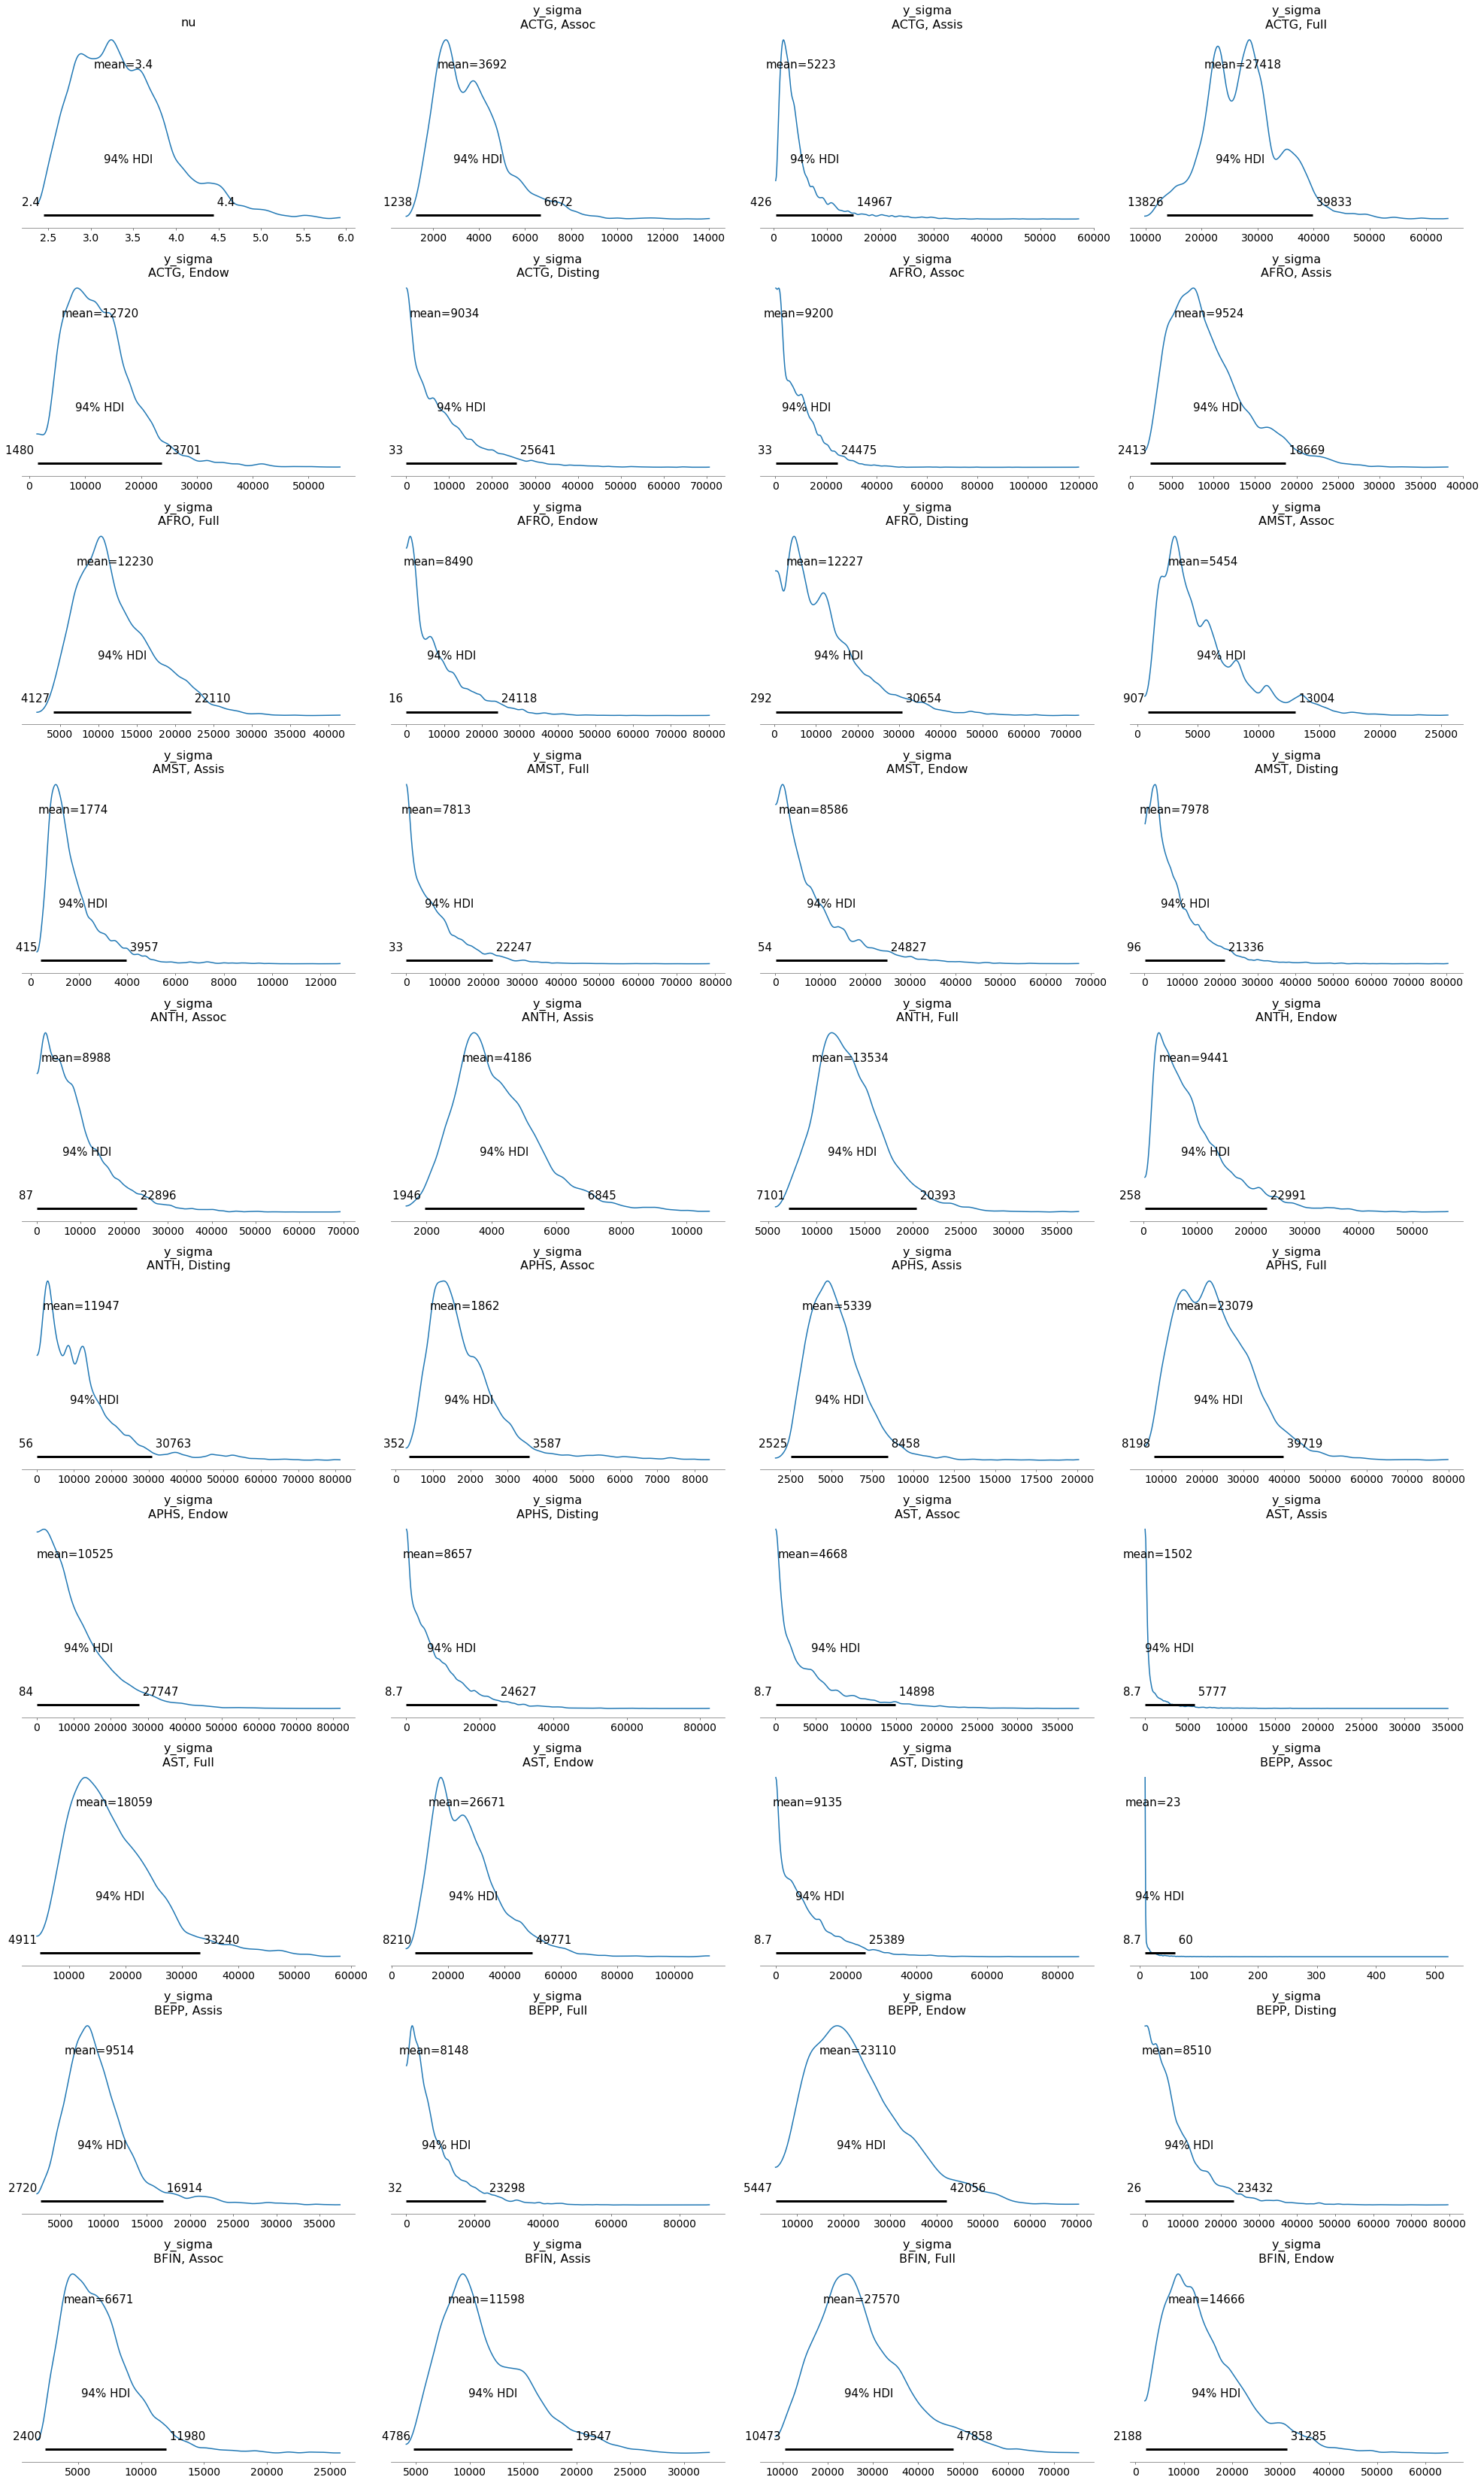

In [14]:
az.plot_posterior(idata_het, ['nu', 'y_sigma'])
plt.tight_layout()

## Split-plot Design

In [15]:
agri_df = pd.read_csv('datasets/SplitPlotAgriData.csv')
agri_df['Field'] = agri_df['Field'].astype('category')
agri_df['Till'] = agri_df['Till'].astype('category')
agri_df['Fert'] = agri_df['Fert'].astype('category')
agri_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Field   99 non-null     category
 1   Till    99 non-null     category
 2   Fert    99 non-null     category
 3   Yield   99 non-null     int64   
dtypes: category(3), int64(1)
memory usage: 2.8 KB


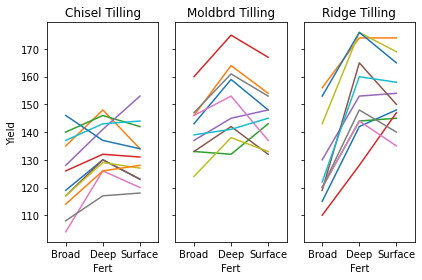

In [16]:
fig, axes = plt.subplots(ncols=3, sharey=True)

for till, ax in zip(agri_df['Till'].cat.categories, axes):
    df = agri_df[agri_df['Till'] == till]

    for field in df['Field'].cat.categories:
        df_ = df[df['Field'] == field]
        sns.lineplot(x='Fert', y='Yield', data=df_, ax=ax)

    ax.set_title(f'{till} Tilling')
    ax.set_xlim(-0.5, 2.5)

fig.tight_layout()